In [24]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

seed = 99
%matplotlib inline  
os.chdir('/Users/Sriram/Desktop/DePaul/Q5/CSC529/SVM-Convex-Images')
#os.chdir('C:\\Users\\SYARLAG1\\Desktop\\SVM-Convex-Images')

In [3]:
train = np.genfromtxt('convex_train.amat')

### Data Preprocessing and Exploration

(Each image is 28x28)

In [10]:
train.shape

(8000, 785)

In [11]:
X = train[:,:-1]
Y = train[:,-1]

In [12]:
X.shape

(8000, 784)

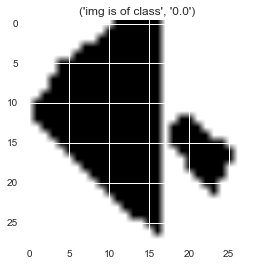

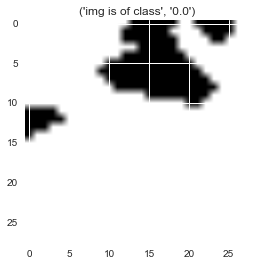

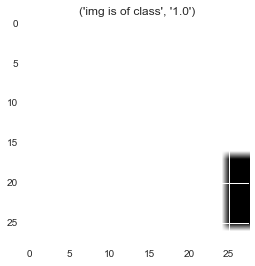

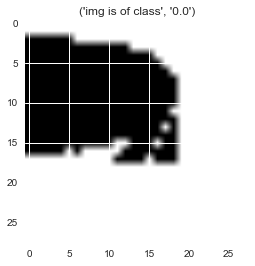

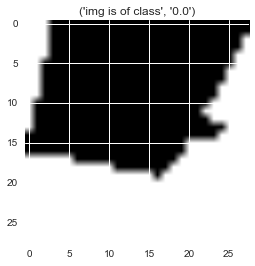

In [13]:
for i in range(5): # let us look at 5 randomly selected images
    rand_int = random.choice(range(X.shape[0]))
    img = X[rand_int]
    plt.imshow(np.reshape(img,[28,28]))
    title = 'img is of class', str(Y[rand_int])
    plt.title(title)
    plt.show()

In [14]:
# checking if there are any NAs or invalid values


In [15]:
# visulize the datapoints using PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_X = pca.fit_transform(X)

In [16]:
# variance explaied by first two components
sum(pca.explained_variance_ratio_[:2])

0.50931709227146749

(-1, 1)

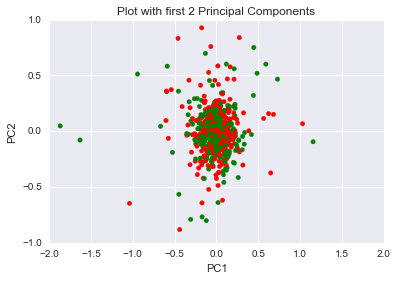

In [17]:
# plotting to see how the results look
colors = ['red' if x == 1 else 'green' for x in list(Y)]
plt.scatter(pca_X[1], pca_X[2], color=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Plot with first 2 Principal Components')
# zooming in to avoid outliers
plt.xlim([-2,2])
plt.ylim([-1,1])

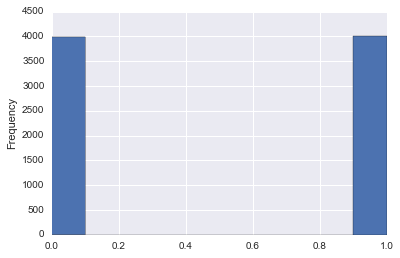

In [18]:
pd.Series(Y).plot(kind='hist') # perfectly balanced --> can use accuracy as performance metric

In [19]:
# there doesnt seem to be any discernable pattern here

### Applying Kernel SVM on the data

In [28]:
from sklearn import svm
from sklearn.cross_validation import KFold

In [21]:
clf = svm.SVC()
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
clf.score(X, Y)

0.67237499999999994

In [44]:
# perform cross validation to determine parameters
#Function to measure the MAE based on different parameters
def calc_params(X, y, clf, param_values, param_name, K):

    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing scores with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):
        #print(param_name, ' = ', param_value)
        
        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation or stratified bootstrap validation
        cv = KFold(len(X), K, shuffle=True, random_state=99)
        
        # iterate over the K folds
        for j, (train, test) in enumerate(cv):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit([X[k] for k in train], y[train])
            
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
       
       # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # plot the training and testing scores in a log scale
    plt.figure()
    if type(param_values[0]) == str: # we are looking at string parameters
        sns.pointplot(param_values,train_scores, palette="Greens_d")
        sns.pointplot(param_values,test_scores, palette="Blues_d")
        plt.title('Green: Train Results, Blue: Test Results')
        plt.xlabel(param_name + " values")
        plt.ylabel("Mean cross validation accuracy value")
        plt.show()
    else:
        plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
        plt.plot(param_values, test_scores, label='Test', alpha=0.4, lw=2, c='g')
        plt.legend(loc=7)
        plt.xlabel(param_name + " values")
        plt.ylabel("Mean cross validation accuracy value")
        plt.show()

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

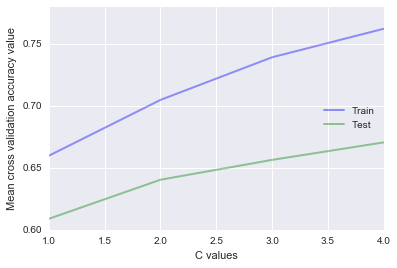

In [29]:
# 3 Fold CV
# test out diff penalities C
svm_cv = svm.SVC(random_state=seed) # initialize the regressor
Cs = list(range(1,5,1))
train_scores, test_scores = calc_params(X, Y, svm_cv, Cs, 'C', 3)

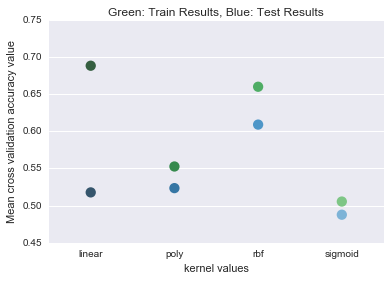

In [45]:
# test out diff penalities C
svm_cv = svm.SVC(random_state=seed) # initialize the regressor
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = calc_params(X, Y, svm_cv, kernels, 'kernel', 3)

In [ ]:
# since RBF clearly provides the better bais-variance trade-off
# We further investigate RBF and tune the sigma value
